# Checking properties of CAVIAR annotations
So far, I've observed that in the 95% credible set I have higher enrichment in the sex-specific annotations than I do in the maximum CPP annotations. Since the latter is just the maximum score for the SNPs in the former, I believe that this could be due to the values in the credible set for sex-specific annotations are just generally smaller. I want to test:
- Distribution of values in each annotation
- whether CpG sites tend to have just one SNP with a high probability or many SNPs with a low probability

In [3]:
library(data.table)
library(tidyverse)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘tibble’ was built under R version 4.1.1”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



In [4]:
male_caviar < -fread("../data/male_meta_caviar_maf01.txt.gz")
female_caviar < -fread("../data/female_meta_caviar_maf01.txt.gz")
male_specific_cpg < -fread("../data/male_specific_top_cpgs_maf01_fdr.txt")
female_specific_cpg < -fread("../data/male_specific_top_cpgs_maf01_fdr.txt")
male_stratified_cpg < -fread("../data/male_top_cpgs_maf01_fdr.txt")
female_stratified_cpg < -fread("../data/female_top_cpgs_maf01_fdr.txt")
cross_cpg < -fread("../data/marginal_top_cpgs_maf01_fdr.txt")
cross_caviar < -fread("../data/marginal_meta_caviar_maf01.txt.gz")

In [5]:
male_max_specific <- male_caviar[male_specific_cpg,.(maxCPP=max(CPP), Category = "Male Specific"),by=.(SNP),on=.(probe)]
male_max_stratified <- male_caviar[male_stratified_cpg,.(maxCPP=max(CPP), Category = "Male Stratified"),by=.(SNP),on=.(probe)]
female_max_specific <- female_caviar[female_specific_cpg,.(maxCPP=max(CPP), Category = "Female Specific"),by=.(SNP),on=.(probe)]
female_max_stratified <- female_caviar[female_stratified_cpg,.(maxCPP=max(CPP), Category = "Female Stratified"),by=.(SNP),on=.(probe)]
cross_max <- cross_caviar[cross_cpg,.(maxCPP=max(CPP), Category = "Cross-sex"),by=.(SNP),on=.(probe)]
all_annot_maxCPP <- rbindlist(list(cross_max,male_max_specific,female_max_specific,male_max_stratified,female_max_stratified))

In [6]:
head(all_annot_maxCPP)

SNP,maxCPP,Category
<chr>,<dbl>,<chr>
rs6684487,0.00115475,Cross-sex
rs12127425,0.02167630,Cross-sex
rs12131377,0.00972080,Cross-sex
rs12132398,0.93685500,Cross-sex
rs4951864,0.99983700,Cross-sex
rs111444624,0.00982859,Cross-sex


## Distribution of values in each annotation

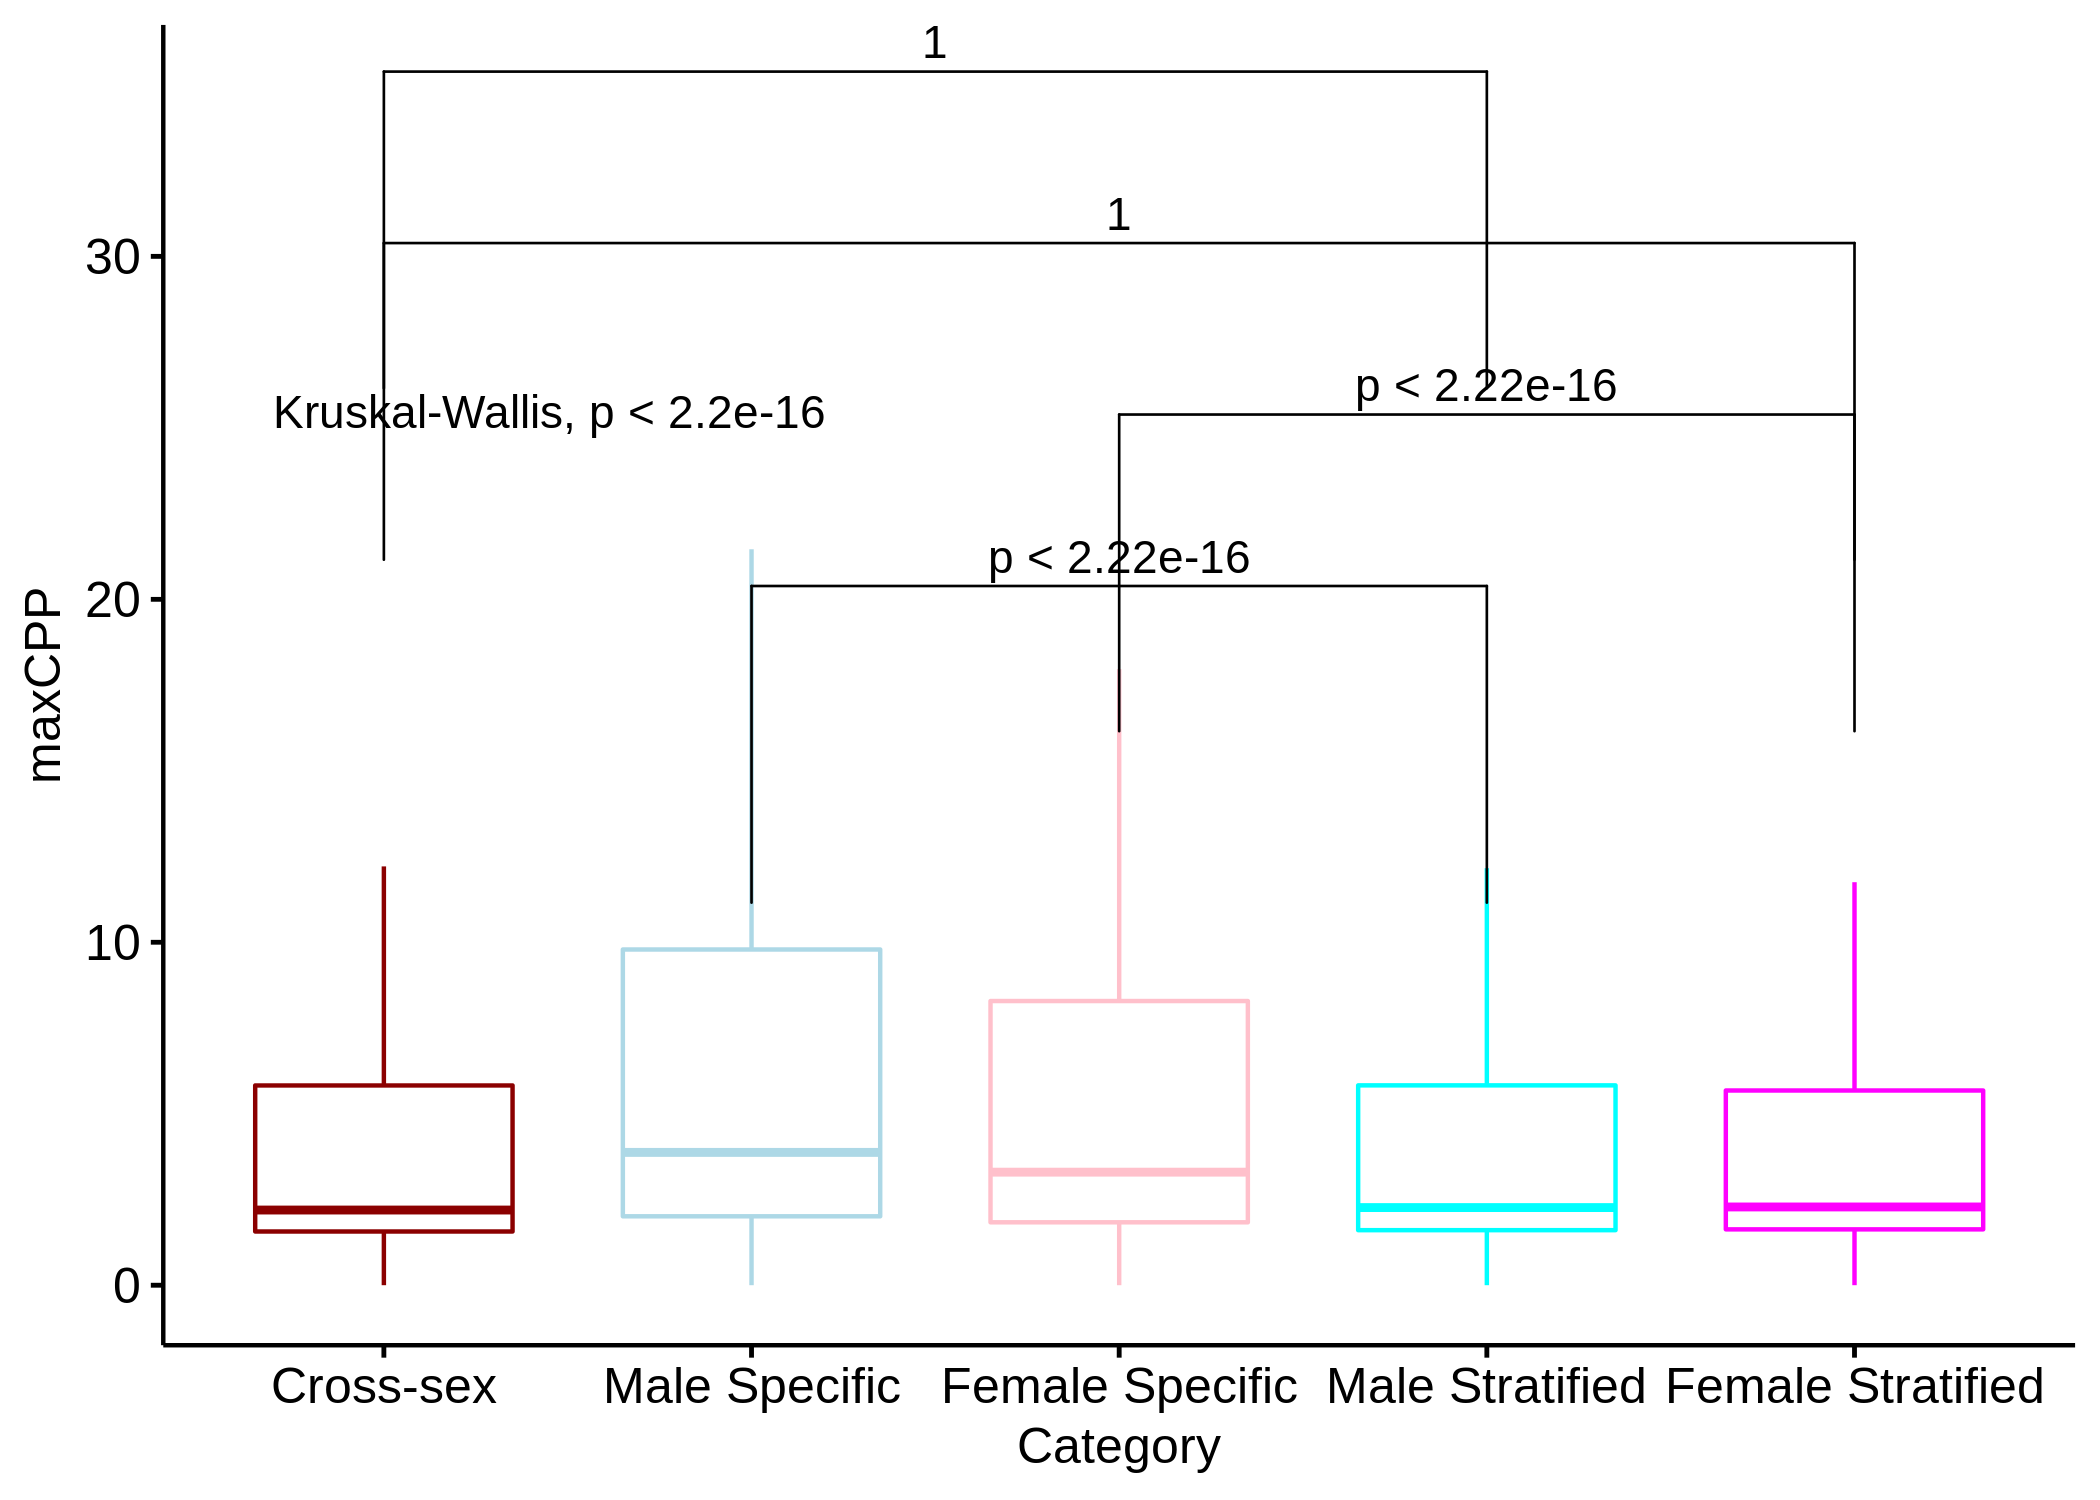

In [77]:
my_comparisons <- list(
    c("Cross-sex", "Male Stratified"),
    c("Cross-sex", "Female Stratified"),
    c("Male Specific", "Male Stratified"),
    c("Female Specific","Female Stratified")
)
options(width= 10, repr.plot.height= 5, repr.plot.res = 300)


to_plot <- na.omit(all_annot_maxCPP[,.(Category,maxCPP=-log10(maxCPP))])
ggboxplot(to_plot,x="Category",y="maxCPP",outlier.shape=NA,color="Category") +
    stat_compare_means(method = "kruskal.test",label.y = 25)+
    stat_compare_means(method = "wilcox.test",comparisons = my_comparisons,label.y = c(20,15,5,10),method.args = list(alternative="greater"))+
    scale_color_manual(values=c("dark red","light blue", "pink", "cyan", "magenta"))+
    coord_cartesian(ylim = c(0,35))+
    theme(legend.position = "none")

In [11]:
to_plot <- na.omit(all_annot_maxCPP[,.(Category,maxCPP=-log10(maxCPP))])
res_great<- pairwise.wilcox.test(to_plot$maxCPP,to_plot$Category,p.adjust.method = "BH",alternative="greater")
res_less<- pairwise.wilcox.test(to_plot$maxCPP,to_plot$Category,p.adjust.method = "BH",alternative="less")

In [20]:
res_great$p.value
res_less$p.value

,Cross-sex,Female Specific,Female Stratified,Male Specific
Female Specific,0,NA,NA,NA
Female Stratified,0,1,NA,NA
Male Specific,0,0,0,NA
Male Stratified,0,1,1,1


,Cross-sex,Female Specific,Female Stratified,Male Specific
Female Specific,1,NA,NA,NA
Female Stratified,1,0,NA,NA
Male Specific,1,1,1.000000e+00,NA
Male Stratified,1,0,2.332746e-16,0


## Are quantiles for each CpG site generally "spread-out" in any given annotation?

In [32]:
all_annot_CPP <- rbindlist(
    list(
        cross_caviar[cross_cpg,.(probe,SNP,CPP,Category= "Cross-sex"),on=.(probe)],
        male_caviar[male_specific_cpg,.(probe,SNP,CPP,Category= "Male Specific"),on=.(probe)],
        female_caviar[female_specific_cpg,.(probe,SNP,CPP,Category= "Female Specific"),on=.(probe)],
        male_caviar[male_stratified_cpg,.(probe,SNP,CPP,Category= "Male Stratified"),on=.(probe)],
        female_caviar[female_stratified_cpg,.(probe,SNP,CPP,Category= "Female Stratified"),on=.(probe)]
    )
)

ERROR: Error in quantile.default(CPP): missing values and NaN's not allowed if 'na.rm' is FALSE


In [40]:
cpg_quant <- na.omit(all_annot_CPP)[,.(
        Min=quantile(CPP,0),
        First=quantile(CPP,0.25),
        Median=quantile(CPP,0.50),
        Last=quantile(CPP,0.75),
        Max=quantile(CPP,1),
        nSNP= .N
    ),by=.(probe,Category)]

In [43]:
fwrite(cpg_quant, "../data/quantiles_cpp_by_cpg.txt")

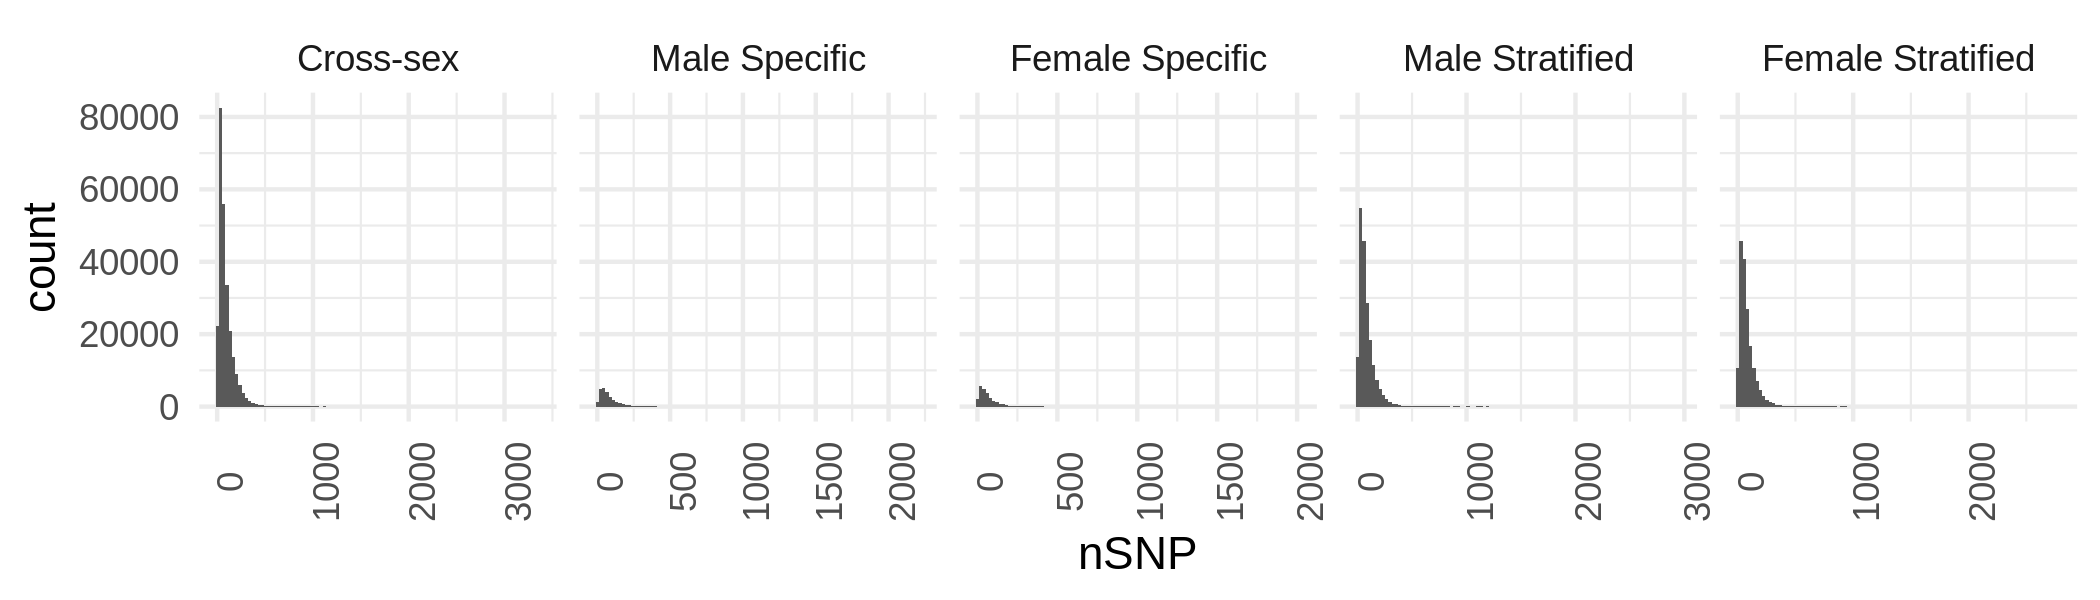

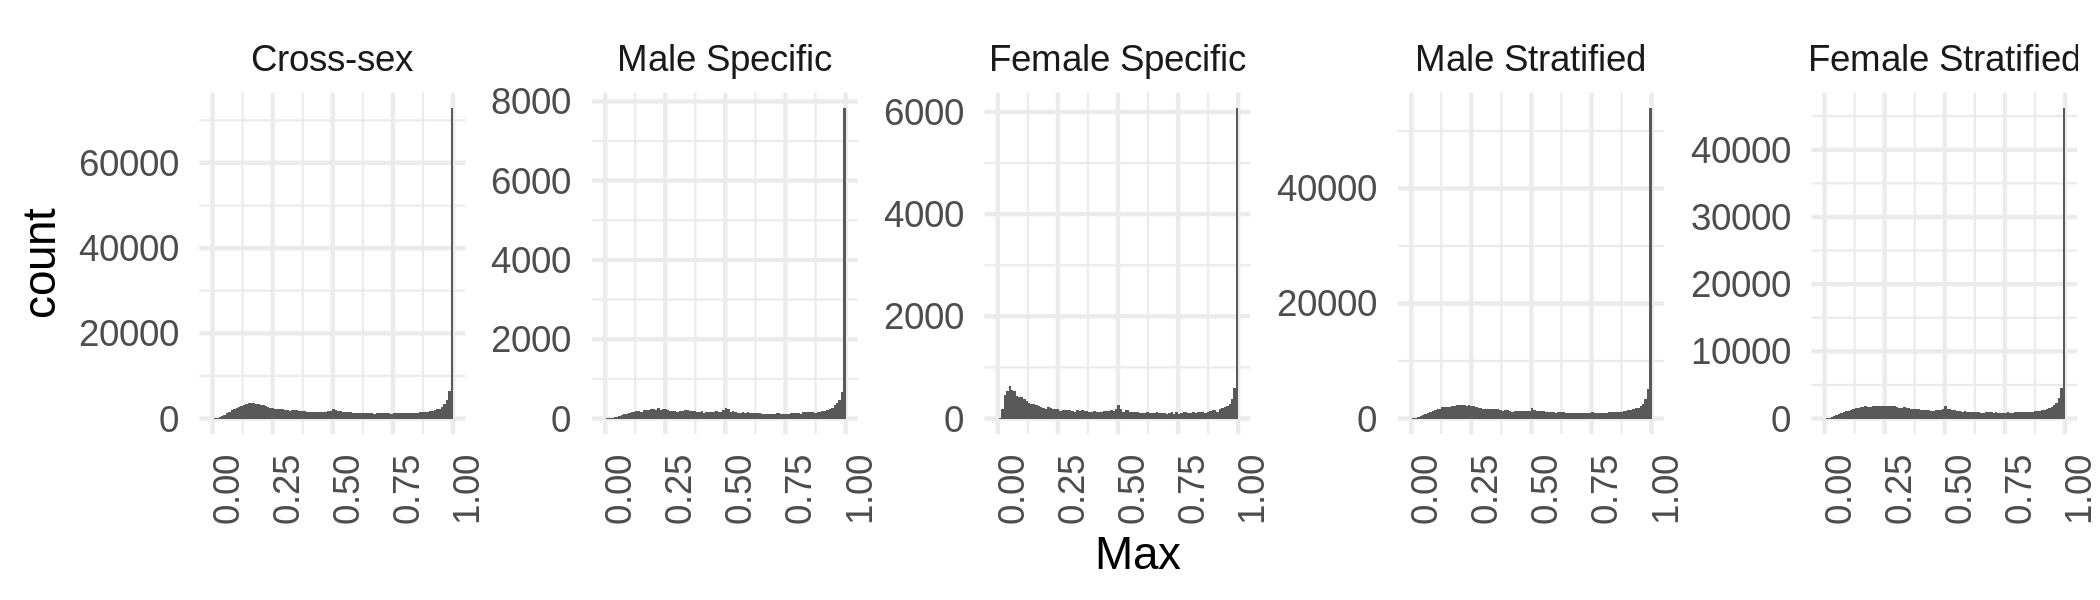

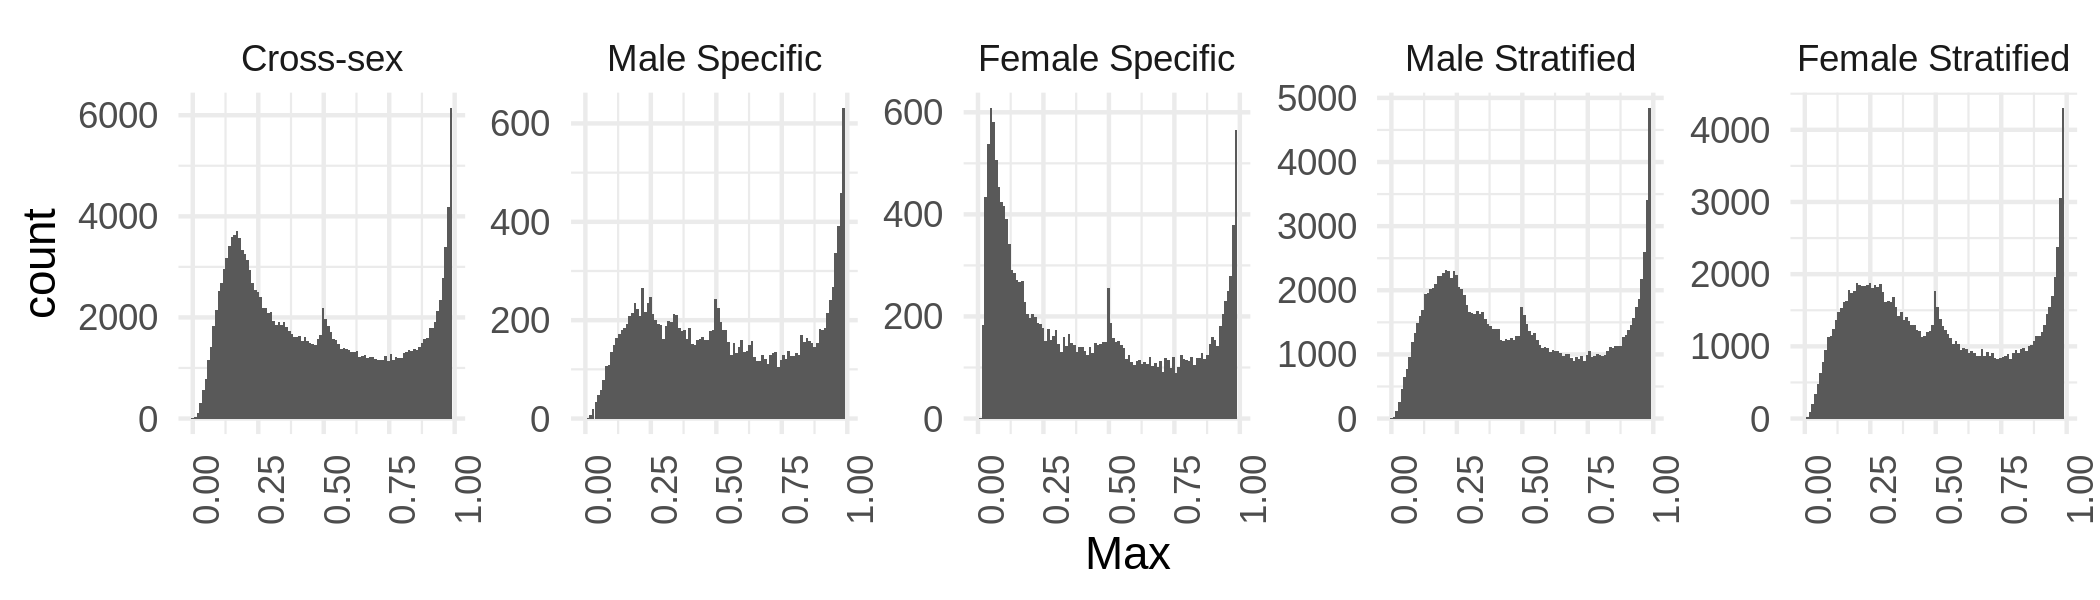

In [72]:
options(width= 15, repr.plot.height= 2, repr.plot.res = 300)
cpg_quant$Category <- factor(cpg_quant$Category,levels=c("Cross-sex","Male Specific","Female Specific", "Male Stratified","Female Stratified"))
ggplot(cpg_quant,aes(nSNP)) +
    geom_histogram(bins=100) +
    facet_wrap(~Category,nrow=1,scales="free_x") + 
    theme_minimal() + 
    theme(axis.text.x=element_text(angle=90))

ggplot(cpg_quant,aes(Max)) +
    geom_histogram(bins=100) +
    facet_wrap(~Category,nrow=1,scales="free_y") + 
    theme_minimal() + 
    theme(axis.text.x=element_text(angle=90))

ggplot(cpg_quant[Max <= 0.99],aes(Max)) +
    geom_histogram(bins=100) +
    facet_wrap(~Category,nrow=1,scales="free_y") + 
    theme_minimal() + 
    theme(axis.text.x=element_text(angle=90))